## Phase 3 Project
Michal Ostrowski

In [79]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

The phone comapny XXXXXX has come to us and asked for recommendations that will lower the amount of people leaving their company (churn)  

# Load the data

In [80]:
# Load the dataset
Telecomdf = pd.read_csv("bigml_59c28831336c6604c800002a.csv")

In [81]:
Telecomdf

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


# Data cleaning

In [82]:
# Iterate through the column names
for col in Telecomdf.columns:
    # Check if the column name contains a space
    if " " in col:
        # Replace the space with an underscore
        new_col = col.replace(" ", "_")
        # Rename the column
        Telecomdf = Telecomdf.rename(columns={col: new_col})

In [83]:
#Looking for null values
print(Telecomdf.isnull().sum())

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64


No values appear to be null in the above cell

In [84]:
#Looking for duplicates
print(Telecomdf.duplicated().sum())

0


No duplicates are present

In [85]:
#making alphabetical values numerical
Telecomdf['international_plan'] = np.where(Telecomdf['international_plan'] == 'yes', 1, 0)
Telecomdf['voice_mail_plan'] = np.where(Telecomdf['voice_mail_plan'] == 'yes', 1, 0)

In [86]:
Telecomdf['churn'] = Telecomdf['churn'].astype(str).replace({'True': 1, 'False': 0})

In [87]:
#creating a new column with total charges
Telecomdf = Telecomdf.assign(total_charge=lambda x: x['total_day_charge'] + x['total_eve_charge'] + x['total_night_charge'] + x['total_intl_charge'])

In [88]:
#removing state, they dont seem right as there are many states but only 3 area codes
Telecomdf.drop(columns=['state'], inplace=True)

In [89]:
#removing '-' from phone number, change column to int
Telecomdf['phone_number'] = Telecomdf['phone_number'].replace("-", "", regex=True).astype(int)

# Exploratory analysis

 finding coefficents of columns with churn as the dependent variable

In [99]:
# Define the target variable
y = Telecomdf['churn']

# Define the independent variables
X = Telecomdf.drop('churn', axis=1)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the data
model.fit(X, y)

# Get the coefficients
coefs = pd.Series(model.coef_, index=X.columns)

# Print the coefficients
print(coefs)

account_length            1.024598e-04
area_code                -8.127683e-05
phone_number             -4.776535e-09
international_plan        3.023682e-01
voice_mail_plan          -1.369536e-01
number_vmail_messages     1.966135e-03
total_day_minutes         3.535786e-02
total_day_calls           3.202560e-04
total_day_charge         -4.130749e-01
total_eve_minutes         9.266258e-02
total_eve_calls           8.032305e-05
total_eve_charge         -1.294977e+00
total_night_minutes      -3.744732e-02
total_night_calls         7.372974e-05
total_night_charge        6.266578e-01
total_intl_minutes       -3.987609e-01
total_intl_calls         -8.228328e-03
total_intl_charge         1.293886e+00
customer_service_calls    5.822834e-02
total_charge              2.124922e-01
dtype: float64


In [90]:
Telecomdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account_length          3333 non-null   int64  
 1   area_code               3333 non-null   int64  
 2   phone_number            3333 non-null   int32  
 3   international_plan      3333 non-null   int32  
 4   voice_mail_plan         3333 non-null   int32  
 5   number_vmail_messages   3333 non-null   int64  
 6   total_day_minutes       3333 non-null   float64
 7   total_day_calls         3333 non-null   int64  
 8   total_day_charge        3333 non-null   float64
 9   total_eve_minutes       3333 non-null   float64
 10  total_eve_calls         3333 non-null   int64  
 11  total_eve_charge        3333 non-null   float64
 12  total_night_minutes     3333 non-null   float64
 13  total_night_calls       3333 non-null   int64  
 14  total_night_charge      3333 non-null   

all data is numerical

In [91]:
Telecomdf.describe()

,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge
count,3333.000000,3333.000000,3.333000e+03,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,...,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,3.746291e+06,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,...,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914,59.449754
std,39.822106,42.371290,2.746626e+05,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,...,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067,10.502261
min,1.000000,408.000000,3.271058e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000,22.930000
25%,74.000000,408.000000,3.508680e+06,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,...,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000,52.380000
50%,101.000000,415.000000,3.748187e+06,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,...,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000,59.470000
75%,127.000000,510.000000,3.985970e+06,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,...,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000,66.480000
max,243.000000,510.000000,4.229964e+06,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,...,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000,96.150000


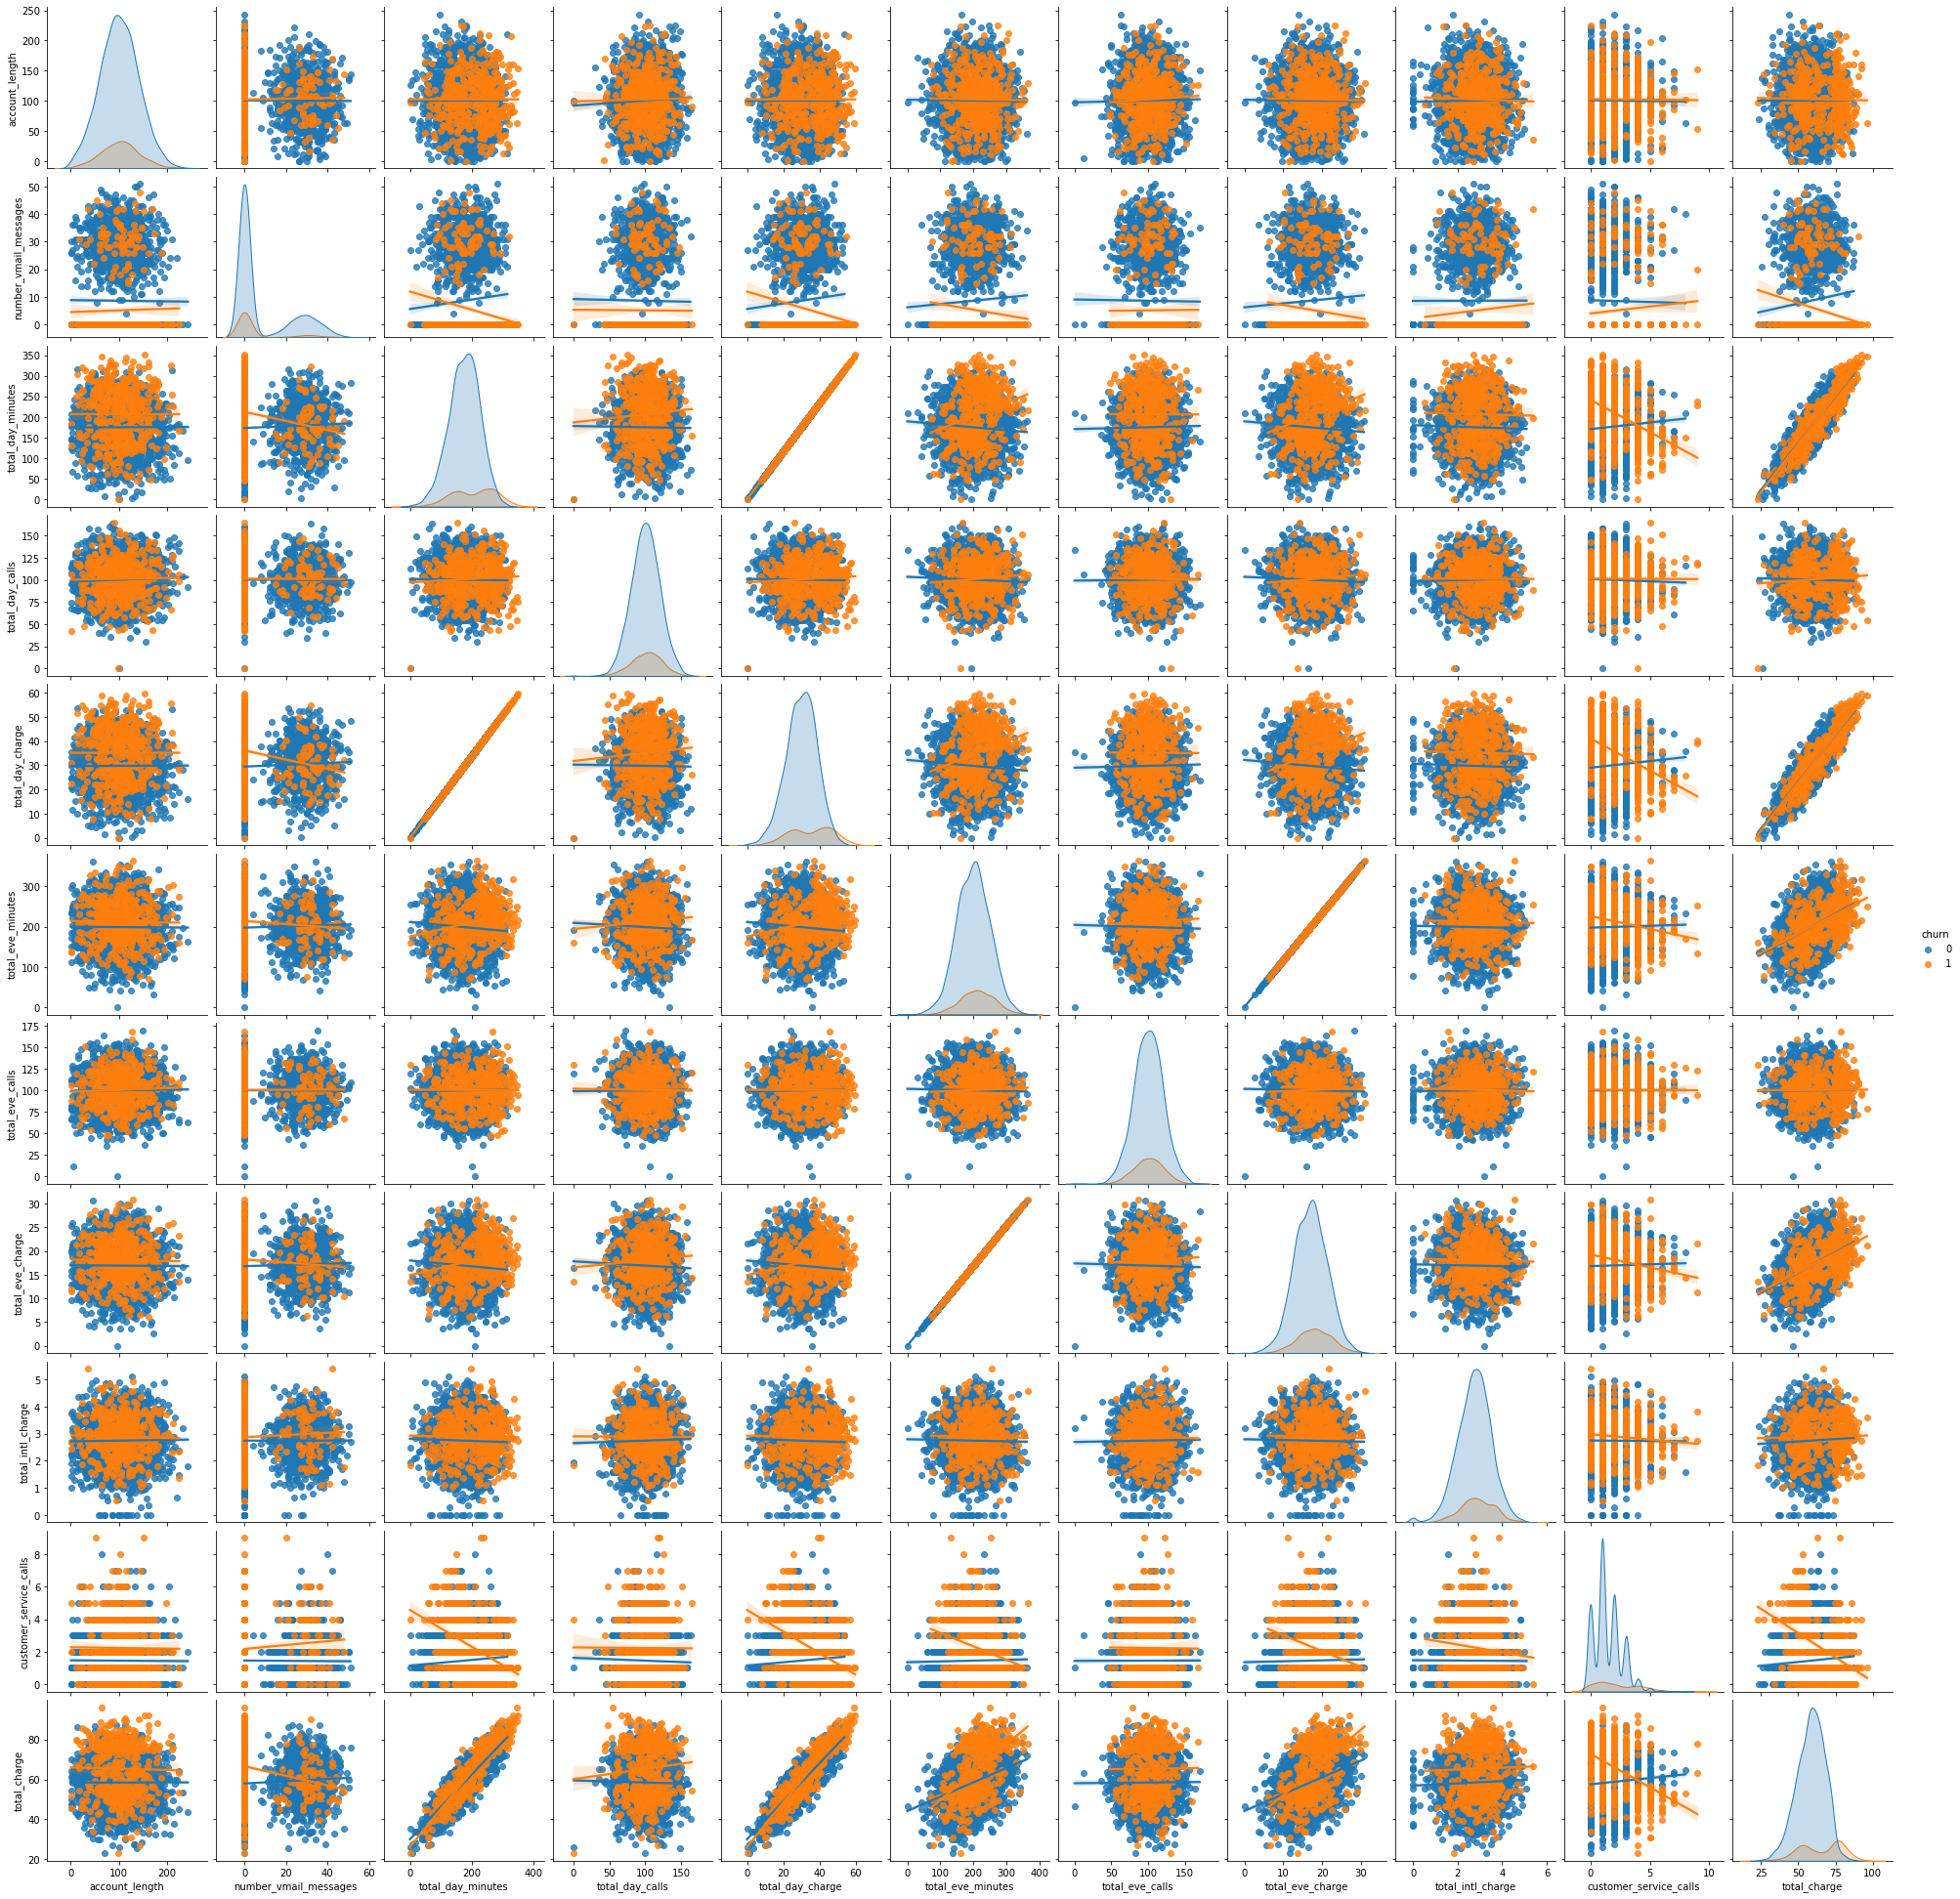

In [92]:
cols = ['account_length', "number_vmail_messages", "total_day_minutes", "total_day_calls", "total_day_charge", "total_eve_minutes", "total_eve_calls", "total_eve_charge", "total_intl_charge", "customer_service_calls", "total_charge"]
sns.pairplot(Telecomdf, vars=cols, kind='reg', hue = "churn")
plt.show()

Using Decision tree model

In [96]:
# Split the data into training and test sets
X = Telecomdf.drop(["churn"], axis=1)
y = Telecomdf["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = DecisionTreeClassifier()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       566
           1       0.77      0.88      0.82       101

    accuracy                           0.94       667
   macro avg       0.88      0.92      0.90       667
weighted avg       0.95      0.94      0.94       667



Using Logistic Regression

In [104]:
# Split the dataset into training and test sets
X = Telecomdf.drop(["churn"], axis=1)
y = Telecomdf["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = LogisticRegression(class_weight="balanced")

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       566
           1       0.15      1.00      0.26       101

    accuracy                           0.15       667
   macro avg       0.58      0.50      0.13       667
weighted avg       0.87      0.15      0.04       667



## one hot encode

In [24]:
# Select the categorical columns to be one-hot encoded
categorical_cols = ["international_plan", "voice_mail_plan", "voice_mail_plan"]

# Create an instance of the OneHotEncoder class
onehot_encoder = OneHotEncoder()

# Fit the one-hot encoder to the categorical columns
onehot_encoded = onehot_encoder.fit_transform(Telecomdf[categorical_cols])

# Convert the one-hot encoded array into a DataFrame
onehot_encoded_df = pd.DataFrame(onehot_encoded.toarray(), columns=onehot_encoder.get_feature_names(categorical_cols))

# Concatenate the one-hot encoded data with the rest of the original DataFrame
Telecomdf_encoded = pd.concat([Telecomdf.drop(categorical_cols, axis=1), onehot_encoded_df], axis=1)

# The resulting DataFrame, Telecomdf_encoded X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42), will have one-hot encoded columns for each of the selected categorical columns.

In [42]:
Telecomdf_encoded

,account_length,area_code,phone_number,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,...,total_intl_charge,customer_service_calls,churn,total_charge,international_plan_0,international_plan_1,voice_mail_plan_0,voice_mail_plan_1,voice_mail_plan_0,voice_mail_plan_1
0,128,415,3824657,25,265.1,110,45.07,197.4,99,16.78,...,2.70,1,0,75.56,1.0,0.0,0.0,1.0,0.0,1.0
1,107,415,3717191,26,161.6,123,27.47,195.5,103,16.62,...,3.70,1,0,59.24,1.0,0.0,0.0,1.0,0.0,1.0
2,137,415,3581921,0,243.4,114,41.38,121.2,110,10.30,...,3.29,0,0,62.29,1.0,0.0,1.0,0.0,1.0,0.0
3,84,408,3759999,0,299.4,71,50.90,61.9,88,5.26,...,1.78,2,0,66.80,0.0,1.0,1.0,0.0,1.0,0.0
4,75,415,3306626,0,166.7,113,28.34,148.3,122,12.61,...,2.73,3,0,52.09,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,4144276,36,156.2,77,26.55,215.5,126,18.32,...,2.67,2,0,60.10,1.0,0.0,0.0,1.0,0.0,1.0
3329,68,415,3703271,0,231.1,57,39.29,153.4,55,13.04,...,2.59,3,0,63.53,1.0,0.0,1.0,0.0,1.0,0.0
3330,28,510,3288230,0,180.8,109,30.74,288.8,58,24.55,...,3.81,2,0,67.74,1.0,0.0,1.0,0.0,1.0,0.0
3331,184,510,3646381,0,213.8,105,36.35,159.6,84,13.57,...,1.35,2,0,57.53,0.0,1.0,1.0,0.0,1.0,0.0


# Data Analysis

Running logisticRegression 

In [29]:
# Split the dataset into training and test sets
X = Telecomdf_encoded.drop([], axis=1)
y = Telecomdf_encoded["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       566
           1       1.00      0.00      0.00       101

    accuracy                           0.85       667
   macro avg       0.92      0.50      0.46       667
weighted avg       0.87      0.85      0.78       667



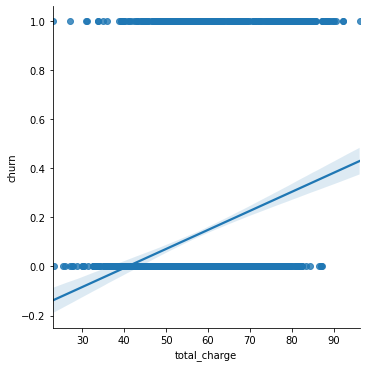

In [36]:
sns.lmplot(x='total_charge', y='churn', data=Telecomdf)

As the total charge goes up, the likliehood of churn increases by a coefficient of .078
With an r-squared value of 0.054, this is not a very good model to explain a higher churn rate.
I recommend to create one single subscription fee. 

# How much can we charge per month?

In [37]:
# Fit a multiple linear regression model
model = smf.ols(formula='total_charge ~ churn', data=Telecomdf).fit()

# Make predictions for a range of churn values
churn_range = pd.DataFrame({'churn': np.linspace(Telecomdf['churn'].min(), Telecomdf['churn'].max(), 100)})
predictions = model.predict(churn_range)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.idxmin()
min_churn = churn_range.iloc[min_index]['churn']

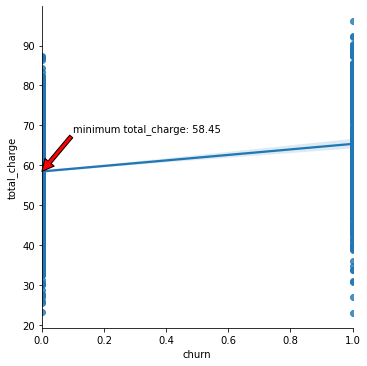

In [38]:
# Create a scatter plot with a multiple linear regression line
sns.lmplot(x='churn', y='total_charge', data=Telecomdf)

# Find the churn value where the predicted total_charge is minimized
min_index = predictions.idxmin()
min_churn = churn_range.iloc[min_index]['churn']

# Annotate the plot with the minimum total_charge and churn values
plt.annotate(f'minimum total_charge: {predictions[min_index]:.2f}', xy=(min_churn, predictions[min_index]), xytext=(min_churn + 0.1, predictions[min_index] + 10), arrowprops={'facecolor': 'red'})

# Label the axes
plt.xlabel('churn')
plt.ylabel('total_charge')

# Show the plot
plt.show()

At this point I see that the point in dollars where people drew the line of when they would cancel their service.  That price was 58.45 dollars.
Seeing this My first recommendation is going to be to create a monthly plan and charge $58.00.


# Comparing churn to account length (time spent with our service)

In [39]:
# Split the dataset into training and test sets
X = Telecomdf.drop(["churn","account_length", 'total_charge'], axis=1)
y = Telecomdf["churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4000)

# Define the model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       566
           1       1.00      0.01      0.02       101

    accuracy                           0.85       667
   macro avg       0.92      0.50      0.47       667
weighted avg       0.87      0.85      0.78       667



After running churn and account_length through this model, the precision is decently high at .85, recall is 1 which means there are very few false negatives, and the f1-score of .92 means this model is doing a good job of predicting outcomes and keeping false positives low.

Text(0.5, 1.0, 'The impact of Account Length on Churn')

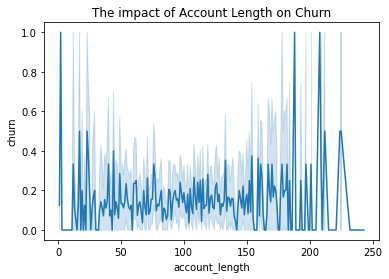

In [40]:
# plot the churn rate on the y-axis and the account length on the x-axis
sns.lineplot(x='account_length', y='churn', data=Telecomdf)
plt.title('The impact of Account Length on Churn')

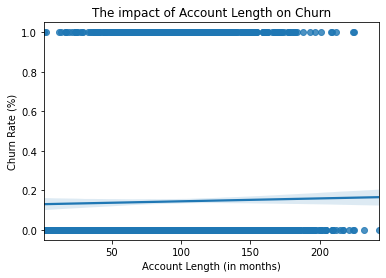

In [41]:
sns.regplot(x='account_length', y='churn', data=Telecomdf)
plt.title('The impact of Account Length on Churn')
plt.xlabel('Account Length (in months)')
plt.ylabel('Churn Rate (%)')
plt.show()

At this point I am seeing that the churn rate gets much higher between 125 and 175 months.  My second suggestion is to offer a loyalty program where your cost goes down close to this point.

In [ ]:
# Split the data into features and labels
features = df.drop("label_column", axis=1)
labels = df["label_column"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# The variables X_train and y_train contain the training data, and X_test and y_test contain the test data.

# Service calls vs Churn Rate

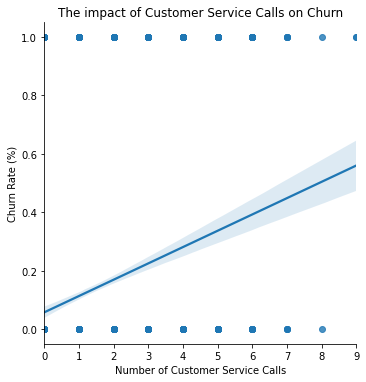

In [42]:
sns.lmplot(x='customer_service_calls', y='churn', data=Telecomdf)
plt.title('The impact of Customer Service Calls on Churn')
plt.xlabel('Number of Customer Service Calls')
plt.ylabel('Churn Rate (%)')
plt.show()

Its clear that customers who suffer from having to call customer service (someone who has a problem) is more likely to leave this company.

Based off this I recommend we do more research into the areas that are more prone to customers calling customer service and look into what is causing these problems.  We need to update/upgrade infastructure possibly?

from these plots above I can see that the more impactful variable to keep churn low would be customer service.

In [43]:
Telecomdf

,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge
0,128,415,3824657,0,1,25,265.1,110,45.07,197.4,...,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56
1,107,415,3717191,0,1,26,161.6,123,27.47,195.5,...,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24
2,137,415,3581921,0,0,0,243.4,114,41.38,121.2,...,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29
3,84,408,3759999,1,0,0,299.4,71,50.90,61.9,...,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80
4,75,415,3306626,1,0,0,166.7,113,28.34,148.3,...,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,192,415,4144276,0,1,36,156.2,77,26.55,215.5,...,18.32,279.1,83,12.56,9.9,6,2.67,2,0,60.10
3329,68,415,3703271,0,0,0,231.1,57,39.29,153.4,...,13.04,191.3,123,8.61,9.6,4,2.59,3,0,63.53
3330,28,510,3288230,0,0,0,180.8,109,30.74,288.8,...,24.55,191.9,91,8.64,14.1,6,3.81,2,0,67.74
3331,184,510,3646381,1,0,0,213.8,105,36.35,159.6,...,13.57,139.2,137,6.26,5.0,10,1.35,2,0,57.53
